# Data Preparation Code
## Prepare data from directories

Importing all need libraries

In [1]:
from __future__ import print_function, division
from skimage import io, transform
from random import randint

import os, uuid, glob, warnings
import numpy as np
import shutil
warnings.filterwarnings("ignore")

Pathes for images and their annotations

In [5]:
ORIGINAL_DATA_DIR = '../data/fl27/original'
CROPPED_DATA_DIR = '../data/fl27/images'
ORIGINAL_ANNOTATION = '../data/fl27/annotation.txt'
CROPPED_ANNOTATION = '../data/fl27/crop_annotation.txt'

TRAIN_SET = '../annotations/trainset.txt'
TEST_SET = '../annotations/testset.txt'

Original images of logos

In [3]:
original_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.jpg'))

Reading from txt files

In [5]:
def read_from_annotation(path):
    file = open(path, "r")
    content = file.readlines()
    new = [x.split(" ")[:-1] for x in content]
    return new

Preparing labels list from annotation

In [4]:
def prepare_labels(annotaton_path):
    arr = read_from_annotation(annotaton_path)
    labels = []
    for item in (arr):
        l = item[1]
        if l not in labels:
            labels.append(l)
        else:
            continue
    return labels
# LABELS = prepare_labels(ORIGINAL_ANNOTATION)

Creating crops and resize them for creating test and train dataset

In [8]:
def create_resized_crops(input_annotation, input_directory,
                        output_annotation, output_directory):
    annotation = read_from_annotation(input_annotation)
    output_annotation = open(output_annotation, 'w')
    for i, data in zip(range(len(annotation)),annotation):
        img_name = data[0]
        img_path = os.path.join(input_directory, img_name)
        image = io.imread(img_path)
        positions = data[-4:]
        x1 = int(positions[0])
        y1 = int(positions[1])
        x2 = int(positions[2])
        y2 = int(positions[3])

        if x1 > x2:
            tmp = x1
            x1 = x2
            x2 = tmp

        if y1 > y2:
            tmp = y1
            y1 = y2
            y2 = tmp
        
        
            
        target = data[1]
#         fl32 - dataset
        crop_resizer(image, target, x1,x1+x2,y1,y1+y2,output_annotation, output_directory)
#         fl27 - dataset
        crop_resizer(image, target, x1,x2,y1,y2,output_annotation, output_directory)
#         crop_resizer(image, target, x1-40,x2,y1,y2,output_annotation, output_directory)
#         crop_resizer(image, target, x1,x2+40,y1,y2,output_annotation, output_directory)
#         crop_resizer(image, target, x1,x2,y1-40,y2,output_annotation, output_directory)
#         crop_resizer(image, target, x1,x2,y1,y2+40,output_annotation, output_directory)

def crop_resizer(image,target, x1,x2,y1,y2, writer,directory):
    crop_img = image[y1:y2, x1:x2]
    file_name = str(uuid.uuid4().hex)+'.jpg'
    try:
        try:
            resized = transform.resize(crop_img,(224, 224))
            io.imsave(os.path.join(directory, file_name), resized)
            note = "{} {} \n".format(file_name, target)
            writer.write(note)
        except ValueError:
            pass
    except IndexError:
        pass
#create_resized_crops(ORIGINAL_ANNOTATION, ORIGINAL_DATA_DIR, CROPPED_ANNOTATION, CROPPED_DATA_DIR)

Dividing images into train and test dataset, prepare SET.TXT files

In [9]:
def train_test_split(crop_ann_path, out_directory, test_size = 1000):
    train = read_from_annotation(crop_ann_path)
    test = []
    for i in range(test_size):
        randIndex = randint(0,len(train)-1)
        test.append(train[randIndex])
        del(train[randIndex])

    trainset = file(TRAIN_SET, "w")
    testset = file(TEST_SET, "w")

    for item in train:
        tmp = "{} {} \n".format(item[0], item[1])
        trainset.write(tmp)
    trainset.close()

    for item in test:
        tmp = "{} {} \n".format(item[0], item[1])
        testset.write(tmp)
    testset.close()
# train_test_split(CROPPED_ANNOTATION,RESIZED_ANNOTATION,5000)

## Creating pytorch dataset 

Importing libraries for pytorch

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
from torch import optim
plt.ion()

Main pytorch dataset class

In [2]:
class MyDataset(Dataset):
    def __init__(self, txt_file, root):
        self.txt_file = txt_file
        self.root = root

    def __len__(self):
        return self.txt_file.shape[0]

    def __getitem__(self, id):
        img_name = os.path.join(self.root, self.txt_file[id][0])
        img = io.imread(img_name)
        logo = int(self.txt_file[id][1])
        image = img.transpose((2, 0, 1))
        img = torch.FloatTensor(image)
        return img,logo

My main labels(in future I want to add new class)

In [8]:
print(LABELS)

['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 'Ferrari', 'Ford', 'Google', 'Heineken', 'HP', 'Intel', 'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma', 'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone', 'Yahoo']


Convert function from simple list into numpy array with categorization

In [9]:
def prepare_num_dataset(annotation_path, set_path):
    arr = read_from_annotation(set_path)
    out = []
    for item in arr:
        tmp = [item[0], LABELS.index(item[1])]
        out.append(tmp)
    out = np.array(out)
    return out

Creating main train and test set, which are suitable for pytorch

In [10]:
train_data = prepare_num_dataset(CROPPED_ANNOTATION, TRAIN_SET)
test_data = prepare_num_dataset(CROPPED_ANNOTATION, TEST_SET)
trainset = MyDataset(train_data, CROPPED_DATA_DIR)
testset = MyDataset(test_data, CROPPED_DATA_DIR)
print("Train size {} items and test size {} items".format(len(trainset), len(testset)))

Train size 16185 items and test size 5000 items


Creating Data Loaders, which send for training batches with fixed size

In [11]:
batch_size = 40
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                            shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset,
                                            batch_size=batch_size,
                                            shuffle=False)

# Training Convolutional Neural Network with 27 classes

## Without any class balancing

Initialize hyper parameters of CNN and number of classes

In [12]:
num_epochs = 30
learning_rate = 0.001
momentum = 0.9

n_classes = 27

Creating CNN class and initialize it with number of classes

In [13]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x
    
cnn = CNN(n_classes)

### Training convolutional neural network

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr = learning_rate, momentum=momentum)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                %(epoch+1, num_epochs, i+1, len(trainset)//batch_size, loss.data[0]))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn-vol-2.pt')

Epoch [1/30], Iter [10/404] Loss: 3.3259
Epoch [1/30], Iter [20/404] Loss: 3.1986
Epoch [1/30], Iter [30/404] Loss: 3.3115
Epoch [1/30], Iter [40/404] Loss: 3.2043
Epoch [1/30], Iter [50/404] Loss: 3.1178
Epoch [1/30], Iter [60/404] Loss: 2.9768
Epoch [1/30], Iter [70/404] Loss: 3.2297
Epoch [1/30], Iter [80/404] Loss: 2.8930
Epoch [1/30], Iter [90/404] Loss: 2.8964
Epoch [1/30], Iter [100/404] Loss: 3.0892
Epoch [1/30], Iter [110/404] Loss: 2.6049
Epoch [1/30], Iter [120/404] Loss: 2.7870
Epoch [1/30], Iter [130/404] Loss: 2.6302
Epoch [1/30], Iter [140/404] Loss: 2.5602
Epoch [1/30], Iter [150/404] Loss: 2.5616
Epoch [1/30], Iter [160/404] Loss: 2.7008
Epoch [1/30], Iter [170/404] Loss: 2.3921
Epoch [1/30], Iter [180/404] Loss: 2.5160
Epoch [1/30], Iter [190/404] Loss: 2.7436
Epoch [1/30], Iter [200/404] Loss: 2.4593
Epoch [1/30], Iter [210/404] Loss: 2.6125
Epoch [1/30], Iter [220/404] Loss: 2.0055
Epoch [1/30], Iter [230/404] Loss: 2.1821
Epoch [1/30], Iter [240/404] Loss: 2.0208
E

Epoch [5/30], Iter [380/404] Loss: 0.2726
Epoch [5/30], Iter [390/404] Loss: 0.3997
Epoch [5/30], Iter [400/404] Loss: 0.1953
Epoch [6/30], Iter [10/404] Loss: 0.3132
Epoch [6/30], Iter [20/404] Loss: 0.4074
Epoch [6/30], Iter [30/404] Loss: 0.2968
Epoch [6/30], Iter [40/404] Loss: 0.3605
Epoch [6/30], Iter [50/404] Loss: 0.2918
Epoch [6/30], Iter [60/404] Loss: 0.2523
Epoch [6/30], Iter [70/404] Loss: 0.1459
Epoch [6/30], Iter [80/404] Loss: 0.0909
Epoch [6/30], Iter [90/404] Loss: 0.1949
Epoch [6/30], Iter [100/404] Loss: 0.1241
Epoch [6/30], Iter [110/404] Loss: 0.1619
Epoch [6/30], Iter [120/404] Loss: 0.4912
Epoch [6/30], Iter [130/404] Loss: 0.0934
Epoch [6/30], Iter [140/404] Loss: 0.3263
Epoch [6/30], Iter [150/404] Loss: 0.1559
Epoch [6/30], Iter [160/404] Loss: 0.1276
Epoch [6/30], Iter [170/404] Loss: 0.2575
Epoch [6/30], Iter [180/404] Loss: 0.2140
Epoch [6/30], Iter [190/404] Loss: 0.1830
Epoch [6/30], Iter [200/404] Loss: 0.3054
Epoch [6/30], Iter [210/404] Loss: 0.3923
E

Epoch [10/30], Iter [340/404] Loss: 0.0577
Epoch [10/30], Iter [350/404] Loss: 0.1162
Epoch [10/30], Iter [360/404] Loss: 0.1089
Epoch [10/30], Iter [370/404] Loss: 0.1600
Epoch [10/30], Iter [380/404] Loss: 0.0014
Epoch [10/30], Iter [390/404] Loss: 0.0289
Epoch [10/30], Iter [400/404] Loss: 0.0521
Epoch [11/30], Iter [10/404] Loss: 0.0461
Epoch [11/30], Iter [20/404] Loss: 0.2173
Epoch [11/30], Iter [30/404] Loss: 0.0454
Epoch [11/30], Iter [40/404] Loss: 0.1530
Epoch [11/30], Iter [50/404] Loss: 0.1740
Epoch [11/30], Iter [60/404] Loss: 0.0174
Epoch [11/30], Iter [70/404] Loss: 0.0123
Epoch [11/30], Iter [80/404] Loss: 0.0174
Epoch [11/30], Iter [90/404] Loss: 0.0982
Epoch [11/30], Iter [100/404] Loss: 0.0136
Epoch [11/30], Iter [110/404] Loss: 0.0686
Epoch [11/30], Iter [120/404] Loss: 0.0155
Epoch [11/30], Iter [130/404] Loss: 0.3826
Epoch [11/30], Iter [140/404] Loss: 0.1463
Epoch [11/30], Iter [150/404] Loss: 0.0511
Epoch [11/30], Iter [160/404] Loss: 0.0732
Epoch [11/30], Iter 

Epoch [15/30], Iter [260/404] Loss: 0.0880
Epoch [15/30], Iter [270/404] Loss: 0.0147
Epoch [15/30], Iter [280/404] Loss: 0.1592
Epoch [15/30], Iter [290/404] Loss: 0.1770
Epoch [15/30], Iter [300/404] Loss: 0.1579
Epoch [15/30], Iter [310/404] Loss: 0.0012
Epoch [15/30], Iter [320/404] Loss: 0.1526
Epoch [15/30], Iter [330/404] Loss: 0.0341
Epoch [15/30], Iter [340/404] Loss: 0.0729
Epoch [15/30], Iter [350/404] Loss: 0.0087
Epoch [15/30], Iter [360/404] Loss: 0.0186
Epoch [15/30], Iter [370/404] Loss: 0.0115
Epoch [15/30], Iter [380/404] Loss: 0.0066
Epoch [15/30], Iter [390/404] Loss: 0.0041
Epoch [15/30], Iter [400/404] Loss: 0.0476
Epoch [16/30], Iter [10/404] Loss: 0.0000
Epoch [16/30], Iter [20/404] Loss: 0.0016
Epoch [16/30], Iter [30/404] Loss: 0.0129
Epoch [16/30], Iter [40/404] Loss: 0.0006
Epoch [16/30], Iter [50/404] Loss: 0.0765
Epoch [16/30], Iter [60/404] Loss: 0.0161
Epoch [16/30], Iter [70/404] Loss: 0.0068
Epoch [16/30], Iter [80/404] Loss: 0.0294
Epoch [16/30], Iter

Epoch [20/30], Iter [180/404] Loss: 0.0017
Epoch [20/30], Iter [190/404] Loss: 0.0063
Epoch [20/30], Iter [200/404] Loss: 0.0016
Epoch [20/30], Iter [210/404] Loss: 0.0000
Epoch [20/30], Iter [220/404] Loss: 0.0000
Epoch [20/30], Iter [230/404] Loss: 0.0002
Epoch [20/30], Iter [240/404] Loss: 0.0167
Epoch [20/30], Iter [250/404] Loss: 0.0122
Epoch [20/30], Iter [260/404] Loss: 0.0036
Epoch [20/30], Iter [270/404] Loss: 0.0091
Epoch [20/30], Iter [280/404] Loss: 0.0685
Epoch [20/30], Iter [290/404] Loss: 0.0336
Epoch [20/30], Iter [300/404] Loss: 0.0012
Epoch [20/30], Iter [310/404] Loss: 0.0003
Epoch [20/30], Iter [320/404] Loss: 0.0051
Epoch [20/30], Iter [330/404] Loss: 0.0005
Epoch [20/30], Iter [340/404] Loss: 0.0359
Epoch [20/30], Iter [350/404] Loss: 0.0119
Epoch [20/30], Iter [360/404] Loss: 0.0044
Epoch [20/30], Iter [370/404] Loss: 0.0000
Epoch [20/30], Iter [380/404] Loss: 0.0878
Epoch [20/30], Iter [390/404] Loss: 0.0431
Epoch [20/30], Iter [400/404] Loss: 0.0347
Epoch [21/3

Epoch [25/30], Iter [100/404] Loss: 0.0011
Epoch [25/30], Iter [110/404] Loss: 0.0624
Epoch [25/30], Iter [120/404] Loss: 0.0010
Epoch [25/30], Iter [130/404] Loss: 0.0064
Epoch [25/30], Iter [140/404] Loss: 0.0817
Epoch [25/30], Iter [150/404] Loss: 0.0118
Epoch [25/30], Iter [160/404] Loss: 0.0010
Epoch [25/30], Iter [170/404] Loss: 0.0600
Epoch [25/30], Iter [180/404] Loss: 0.0111
Epoch [25/30], Iter [190/404] Loss: 0.0050
Epoch [25/30], Iter [200/404] Loss: 0.0351
Epoch [25/30], Iter [210/404] Loss: 0.0033
Epoch [25/30], Iter [220/404] Loss: 0.0000
Epoch [25/30], Iter [230/404] Loss: 0.0912
Epoch [25/30], Iter [240/404] Loss: 0.0259
Epoch [25/30], Iter [250/404] Loss: 0.0000
Epoch [25/30], Iter [260/404] Loss: 0.0011
Epoch [25/30], Iter [270/404] Loss: 0.1058
Epoch [25/30], Iter [280/404] Loss: 0.0020
Epoch [25/30], Iter [290/404] Loss: 0.0159
Epoch [25/30], Iter [300/404] Loss: 0.1588
Epoch [25/30], Iter [310/404] Loss: 0.0001
Epoch [25/30], Iter [320/404] Loss: 0.0001
Epoch [25/3

Epoch [30/30], Iter [20/404] Loss: 0.0005
Epoch [30/30], Iter [30/404] Loss: 0.0013
Epoch [30/30], Iter [40/404] Loss: 0.0031
Epoch [30/30], Iter [50/404] Loss: 0.0016
Epoch [30/30], Iter [60/404] Loss: 0.0012
Epoch [30/30], Iter [70/404] Loss: 0.0440
Epoch [30/30], Iter [80/404] Loss: 0.0006
Epoch [30/30], Iter [90/404] Loss: 0.0516
Epoch [30/30], Iter [100/404] Loss: 0.0003
Epoch [30/30], Iter [110/404] Loss: 0.0008
Epoch [30/30], Iter [120/404] Loss: 0.0663
Epoch [30/30], Iter [130/404] Loss: 0.0007
Epoch [30/30], Iter [140/404] Loss: 0.0007
Epoch [30/30], Iter [150/404] Loss: 0.0788
Epoch [30/30], Iter [160/404] Loss: 0.0622
Epoch [30/30], Iter [170/404] Loss: 0.0134
Epoch [30/30], Iter [180/404] Loss: 0.0600
Epoch [30/30], Iter [190/404] Loss: 0.0047
Epoch [30/30], Iter [200/404] Loss: 0.0007
Epoch [30/30], Iter [210/404] Loss: 0.0775
Epoch [30/30], Iter [220/404] Loss: 0.0001
Epoch [30/30], Iter [230/404] Loss: 0.0012
Epoch [30/30], Iter [240/404] Loss: 0.0040
Epoch [30/30], Iter

### Testing neural network on validation set

In [17]:
import timeit
start_time = timeit.default_timer()
cnn = CNN(n_classes)
cnn.load_state_dict(torch.load('cnn-vol-2.pt'))
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

elapsed = timeit.default_timer() - start_time
print('Test Accuracy of the model on the test images: %d %%' % (100 * correct / total))
print('Time for running: %d' % (elapsed))

Test Accuracy of the model on the test images: 98 %
Time for running: 125


CNN trained on 16K cropped images and tested on 5K images. Dataset created from 4332 distinct(unique) images. Then, shifted by x1, x2 and so on. Generated new dataset has 21K images. CNN trained on 30 batched dataset with 0.001 learning rate and 0.9 momentum. Epochs count = 30.

Here I want to show plot with epoch num and loss

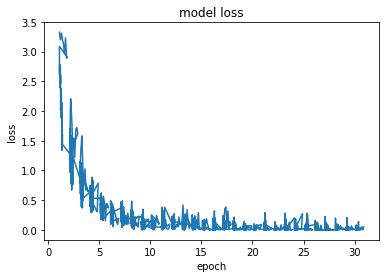

In [89]:
loss_file = 'cnn-vol-2-trained-losses.txt' 
def read_from_loss(file):
    with open (file, "r") as f:
        content = f.readlines()
        content = [x.split(' ') for x in content]
        content = [[x[i].split('\n')[0] for i in range(len(x)) if i%2!=0] for x in content]
        content = [[x[0]+x[1] , x[2]] for x in content]
    data = []
    for item in content:
        tmp = item[0].split(',')
        num = ""
        for t in tmp:
            num += (t.split('/')[0].split('[')[1]) + '.'
        iteration = float(num[:-1])
        data.append([iteration, float(item[1])])
    data = np.array(data)
    plt.plot(data[: , 0], data[: , 1])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
read_from_loss(loss_file)

# Preparing FlickrLogos - 32 Dataset for train/test part

In [3]:
ORIGINAL_DATA_DIR = '../data/fl32/original'
CROPPED_DATA_DIR = '../data/fl32/images'
ORIGINAL_ANNOTATION = '../data/fl32/annotation.txt'
CROPPED_ANNOTATION = '../data/fl32/crop_annotation.txt'

TRAIN_SET = '../annotations/trainset-32.txt'
TEST_SET = '../annotations/testset-32.txt'

Preparing labels with new class - *'no logo'*

In [11]:
LABELS = prepare_labels(ORIGINAL_ANNOTATION)
LABELS.append('nologo')

Creating resized crop logos from FL32 dataset

In [ ]:
create_resized_crops(ORIGINAL_ANNOTATION, ORIGINAL_DATA_DIR, CROPPED_ANNOTATION, CROPPED_DATA_DIR)